## Imports and settings

In [1]:
import os
import pandas as pd 
import numpy as np
import optuna
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', None)

## Loading data

In [3]:
df_monthly = pd.read_csv("df_monthly.csv",low_memory=False)

## Exploring data

In [4]:
df_monthly.shape

(24107, 44)

In [5]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date_month                  24107 non-null  object 
 1   accounts_id                 24107 non-null  int64  
 2   plan_name                   24090 non-null  object 
 3   mrr                         22712 non-null  float64
 4   new_total_mentions          22178 non-null  float64
 5   sessions_nr                 16800 non-null  float64
 6   total_pageviews_nr          16800 non-null  float64
 7   min_pv_nr                   16800 non-null  float64
 8   max_pv_nr                   16800 non-null  float64
 9   avg_pv_nr                   16800 non-null  float64
 10  total_session_duration_min  16800 non-null  float64
 11  min_sess_min                16800 non-null  float64
 12  max_sess_min                16800 non-null  float64
 13  avg_sess_min                168

In [6]:
# Ensure 'date_month' is in datetime format
df_monthly['date_month'] = pd.to_datetime(df_monthly['date_month'])

# Sort DataFrame by 'accounts_id' and 'date_month'
df_monthly = df_monthly.sort_values(by=['accounts_id', 'date_month'])

# Calculate the subscription month as the rank of 'date_month' within each group of 'accounts_id'
df_monthly['subscription_month'] = df_monthly.groupby('accounts_id')['date_month'].rank(method='dense').astype(int)

In [7]:
df_monthly = df_monthly.drop(columns=["why_they_track", "projects_count", "is_client"])

In [8]:
df_monthly.shape

(24107, 42)

In [9]:
additional_cols = ["date_month", "accounts_id"]

target_col = "next_month_churn"

num_cols = [
    "mrr",
    "new_total_mentions",
    "sessions_nr",
    "total_pageviews_nr",
    "min_pv_nr",
    "max_pv_nr",
    "avg_pv_nr",
    "total_session_duration_min",
    "min_sess_min",
    "max_sess_min",
    "avg_sess_min",
    "users_nr",    
    "users_limit",
    "subscription_month",
]

flag_cols = [
    "is_edu_email",
    "is_organic_sale",
    "is_pre_individual",	
    "is_pst_individual",
    "is_pre_personal",
    "is_pst_personal",	
    "is_connected",	
    "is_pst_connected",
    "is_pre_demo",	
    "is_pst_demo",
    "is_twitter_enabled",
    "is_fb_integrated",
]

categorical_cols = [
    "plan_name",
    "email_class",
    "register_platform",
    "web_mobile",
    "first_device_type",
    "country_name",
    "first_state",
    "continent",
    "is_unknown_region",
    "pgsql_landing",
    "heap_landing",
    "first_landing",
    "landings_grouped",
]

In [10]:
for c in categorical_cols:
    print(c, "-",len(df_monthly[c].unique()))

plan_name - 5
email_class - 3
register_platform - 3
web_mobile - 3
first_device_type - 4
country_name - 120
first_state - 382
continent - 8
is_unknown_region - 3
pgsql_landing - 129
heap_landing - 139
first_landing - 132
landings_grouped - 4


In [11]:
# assign tablet to mobile class
df_monthly["first_device_type"] = df_monthly["first_device_type"].replace({"Tablet": "Mobile"})

In [12]:
# replace undefined continent with nan value
df_monthly["continent"] = df_monthly["continent"].replace({"undefined": np.nan})

In [13]:
df_monthly = df_monthly.drop(
    columns=[
        "country_name",
        "first_state",
        "pgsql_landing",
        "heap_landing",
        "first_landing",
    ]
)

In [14]:
categorical_cols = [c for c in categorical_cols if c not in [
        "country_name",
        "first_state",
        "pgsql_landing",
        "heap_landing",
        "first_landing",
    ]]

In [15]:
categorical_cols

['plan_name',
 'email_class',
 'register_platform',
 'web_mobile',
 'first_device_type',
 'continent',
 'is_unknown_region',
 'landings_grouped']

In [16]:
for c in flag_cols: 
    df_monthly[c] = df_monthly[c].astype(bool)

In [17]:
def plot_cat_vs_churn(df, cat_col):
    # Example aggregation by count
    churn_counts = df.groupby([cat_col, 'next_month_churn']).size().unstack(fill_value=0)
    
    # If you prefer proportions over counts
    churn_proportions = churn_counts.div(churn_counts.sum(axis=1), axis=0)
    
    # Plotting the churn counts
    churn_counts.plot(kind='bar', stacked=True)
    plt.title(f'Churn Counts by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Counts')
    plt.xticks(rotation=45)  # Rotate category labels for better readability
    plt.legend(title='Next Month Churn')
    plt.show()
    
    # Or, plotting the churn proportions
    churn_proportions.plot(kind='bar', stacked=True)
    plt.title(f'Churn Proportions by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)  # Rotate category labels for better readability
    plt.legend(title='Next Month Churn')
    plt.show()

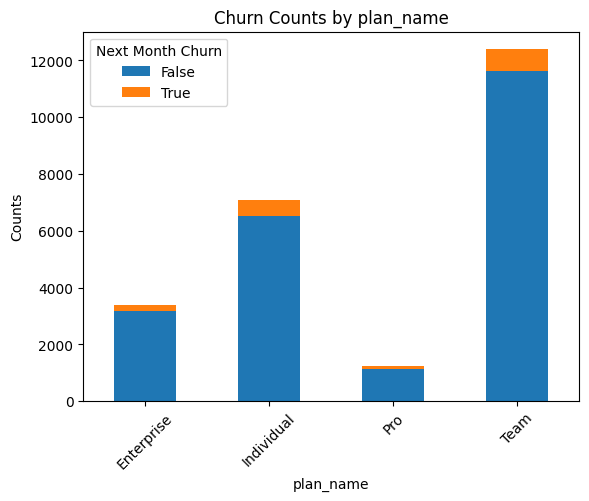

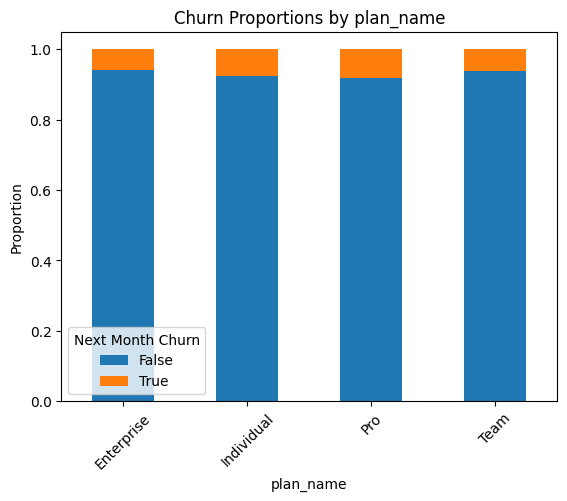

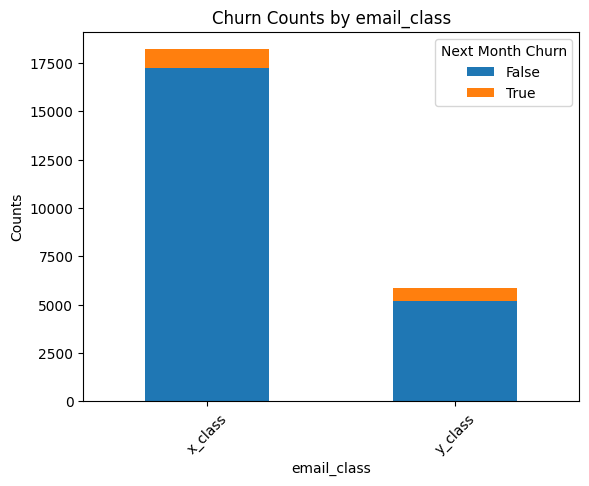

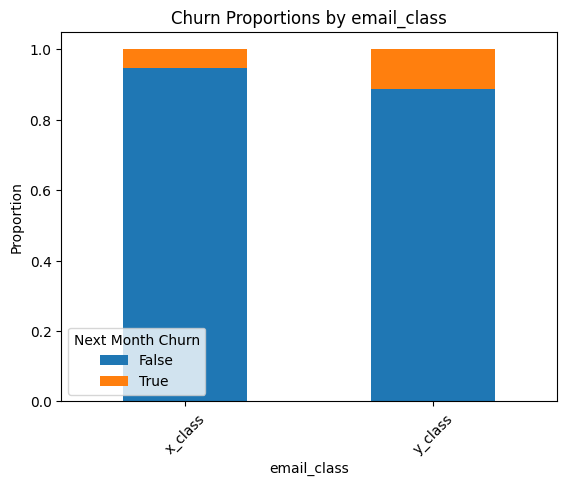

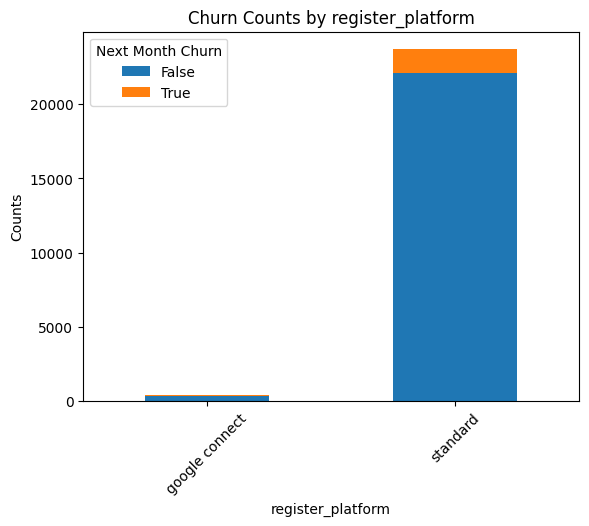

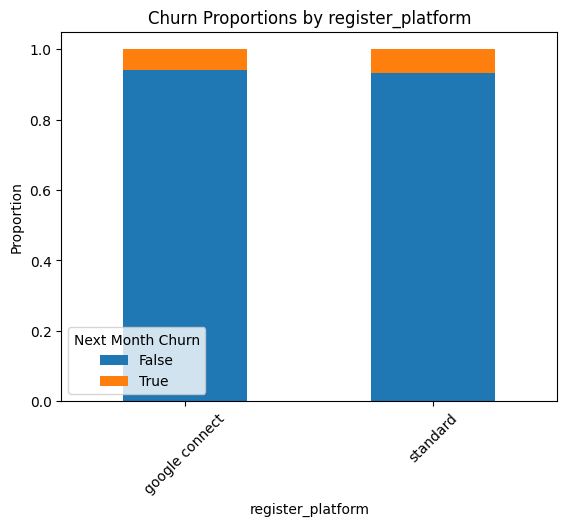

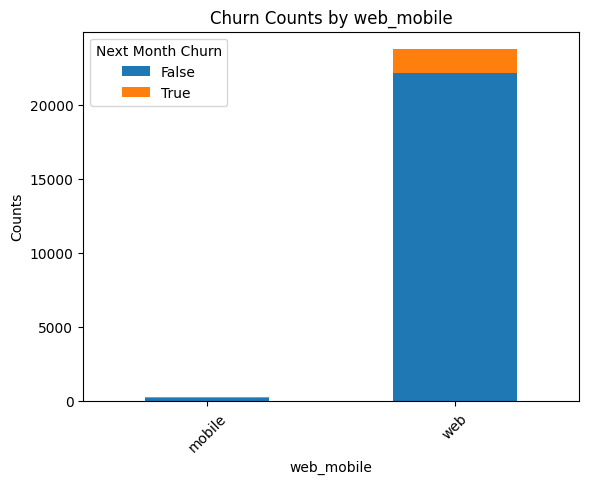

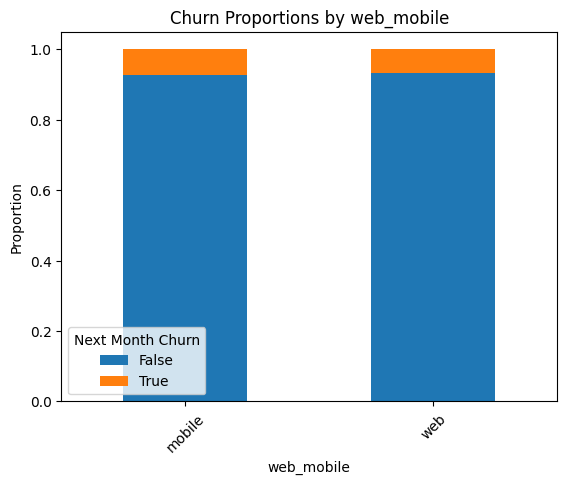

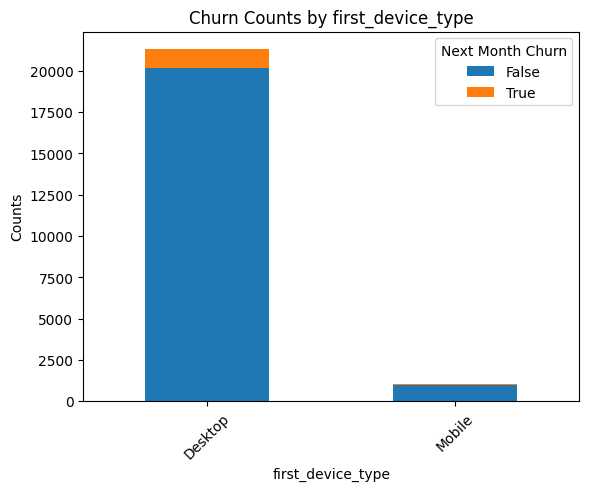

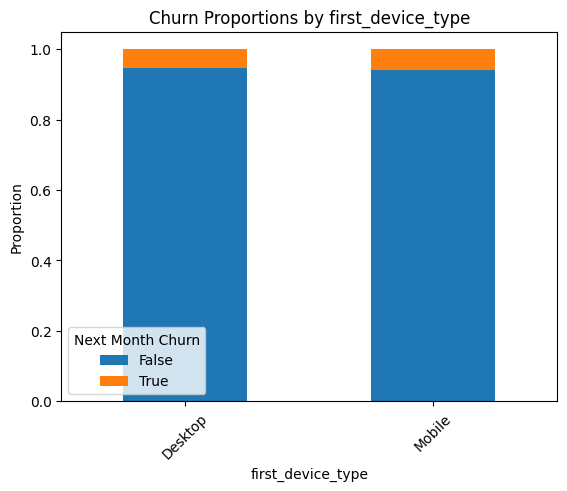

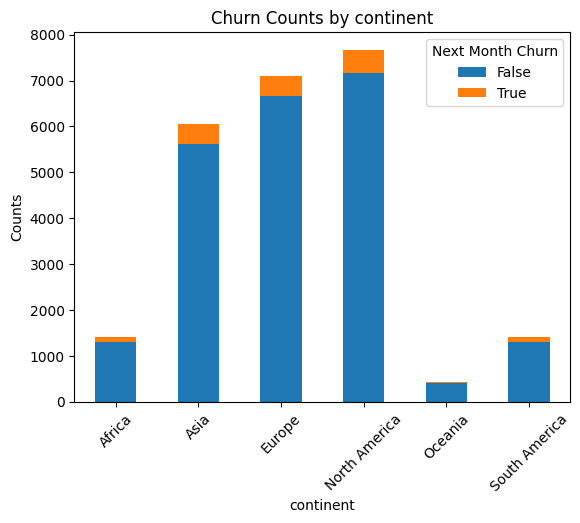

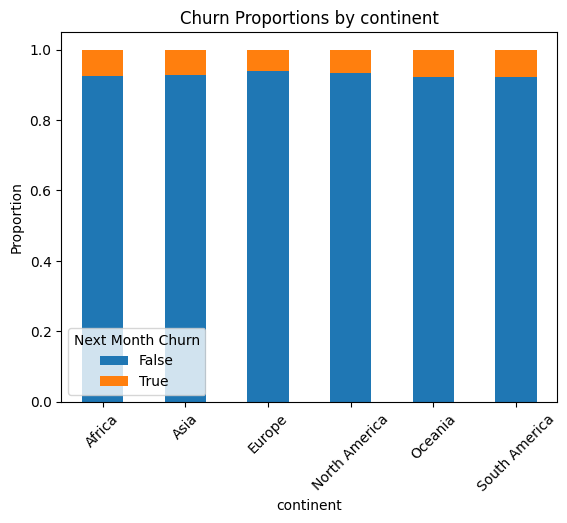

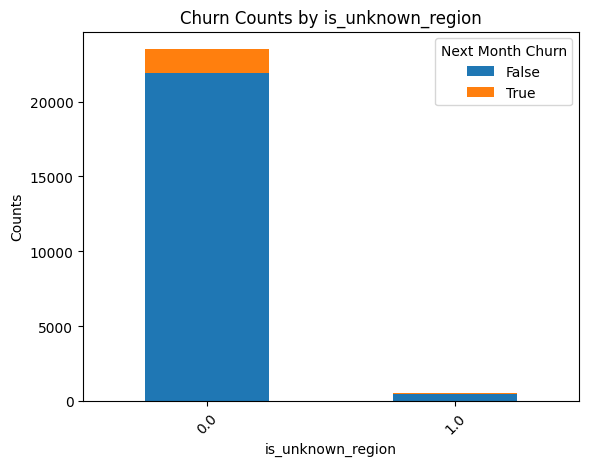

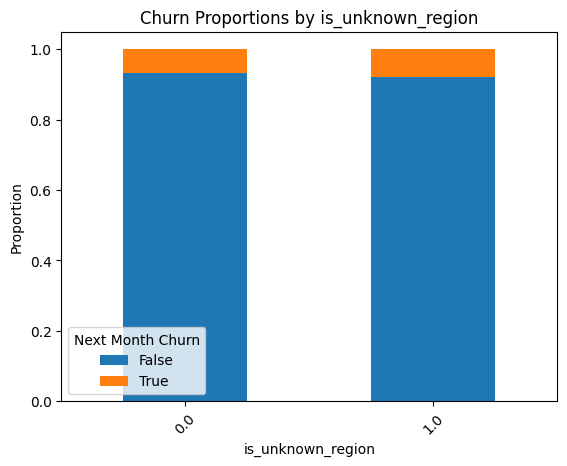

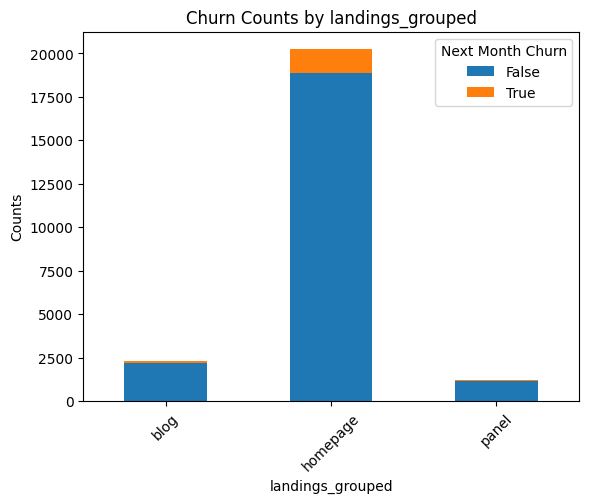

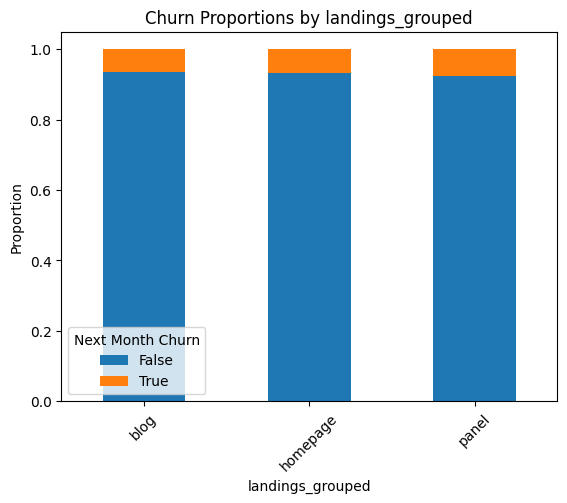

In [18]:
for c in categorical_cols: 
    plot_cat_vs_churn(df_monthly, c)

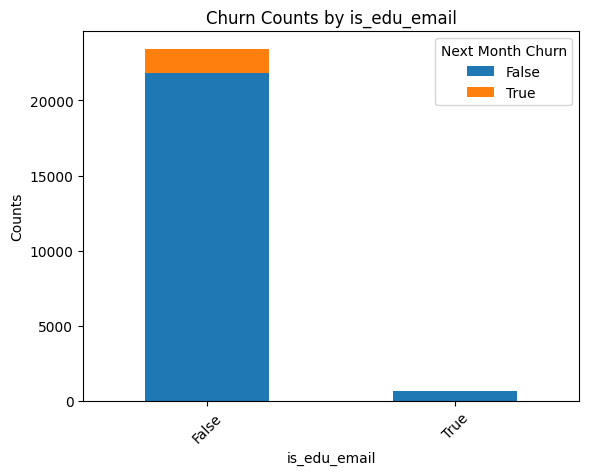

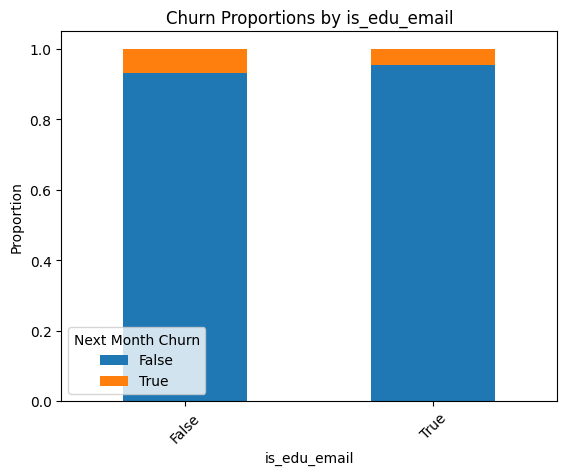

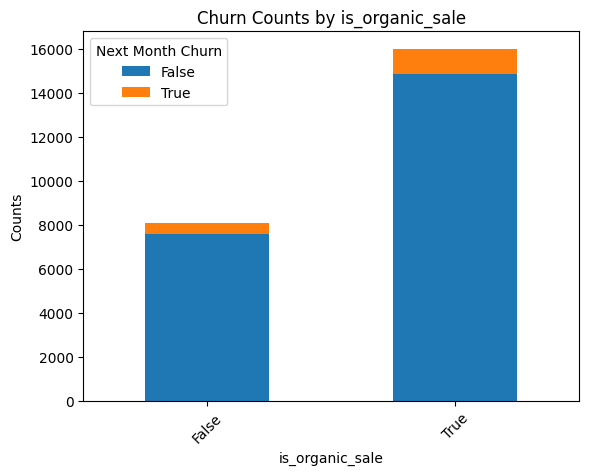

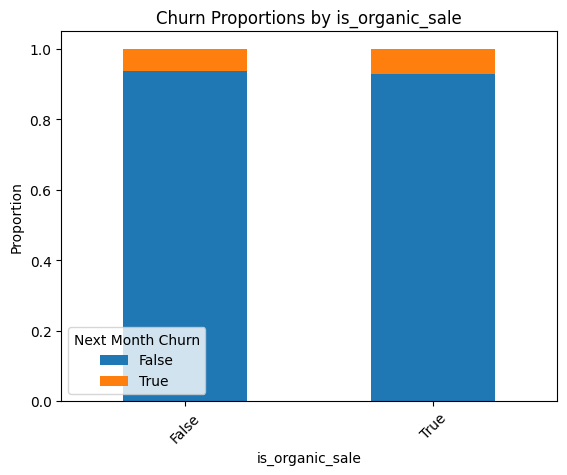

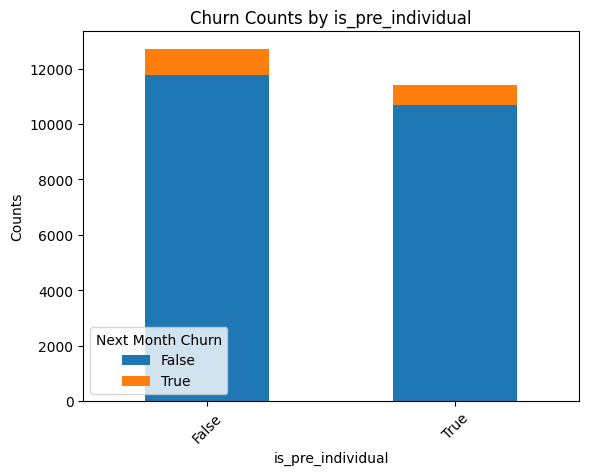

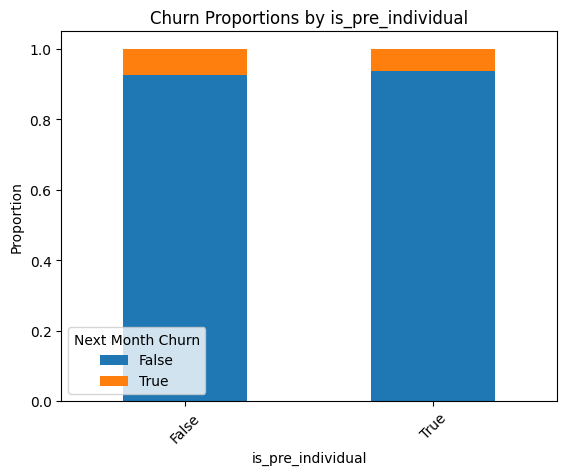

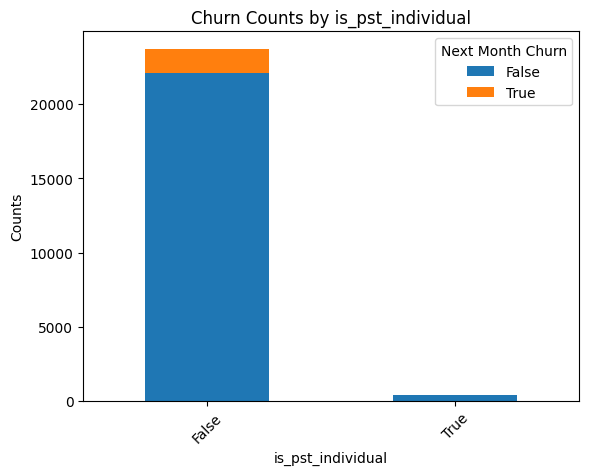

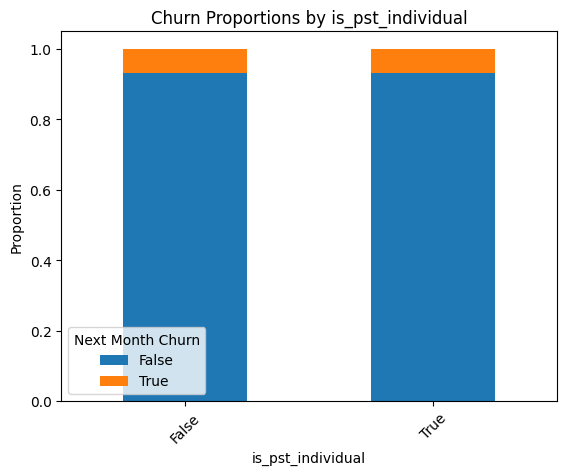

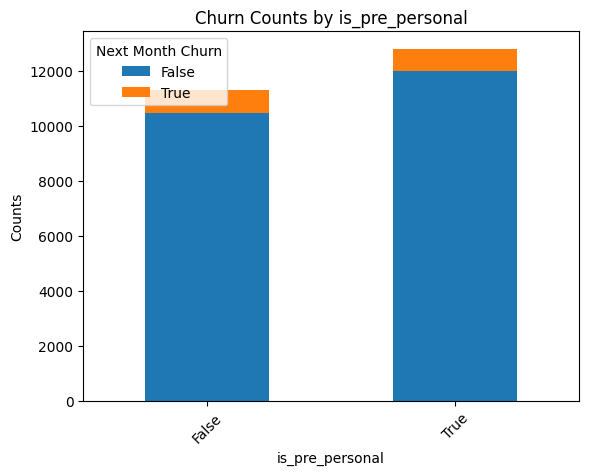

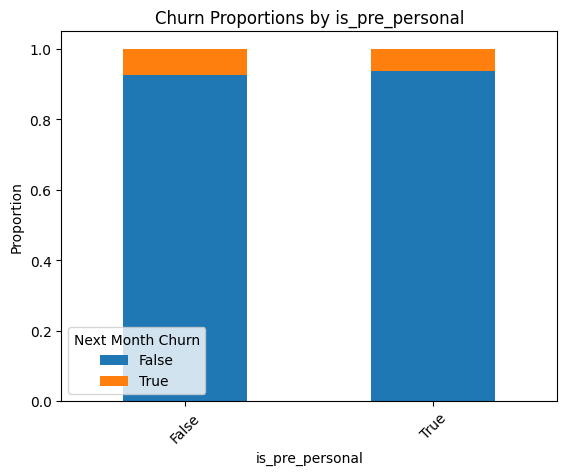

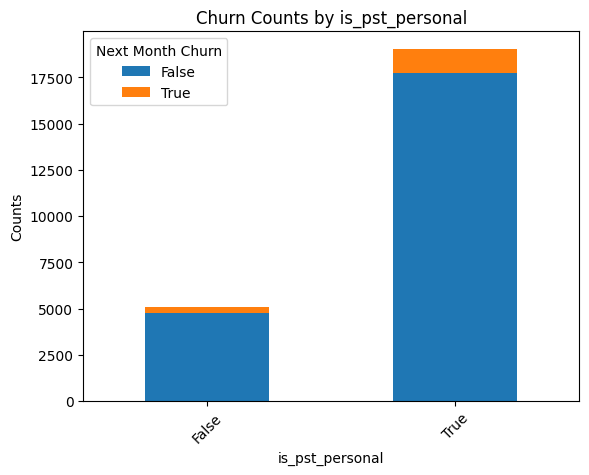

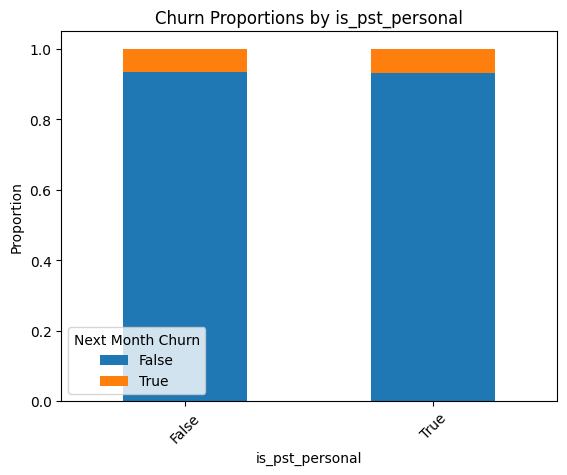

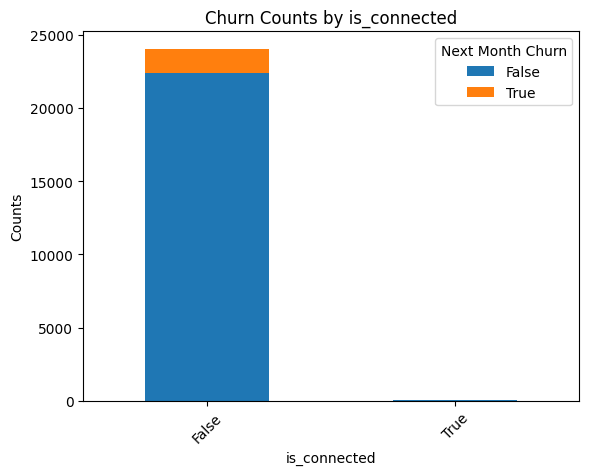

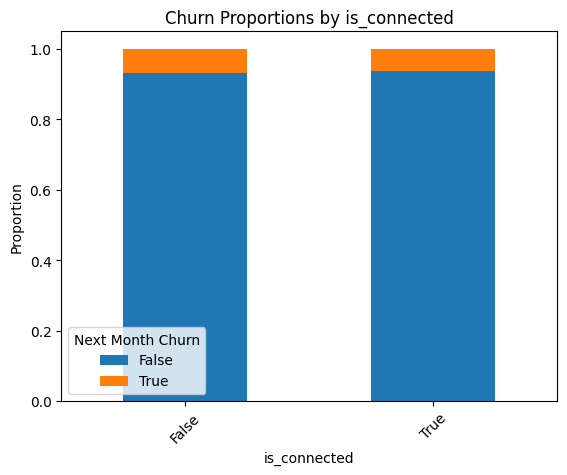

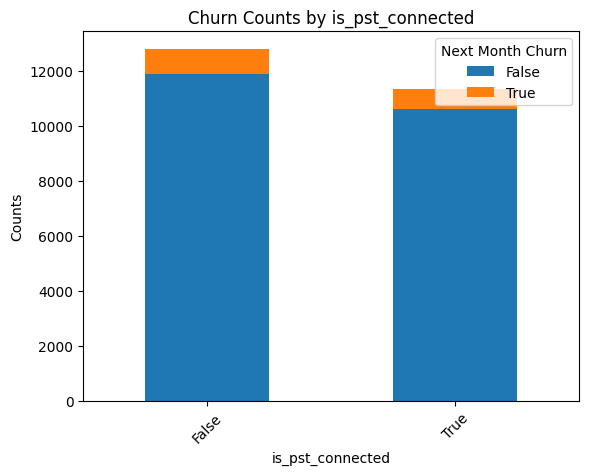

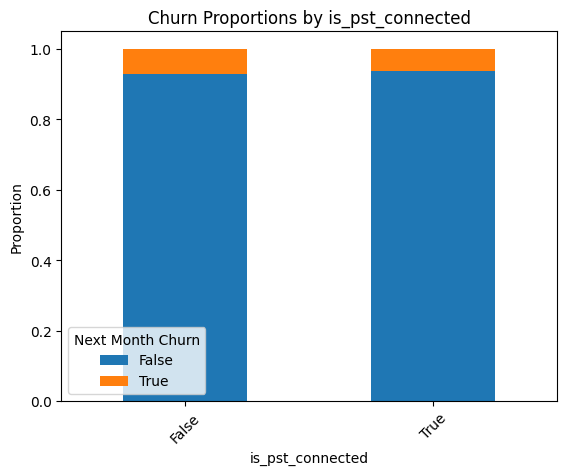

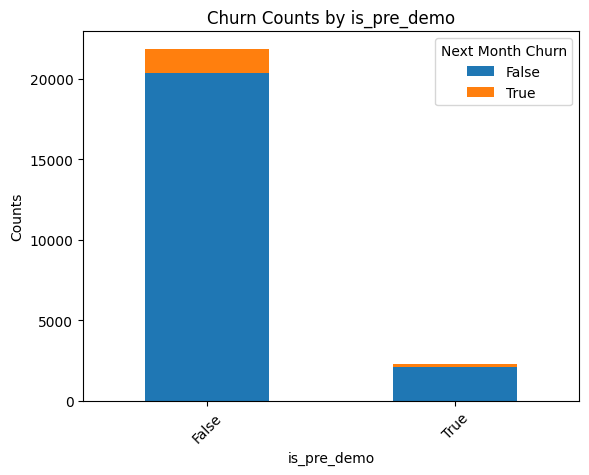

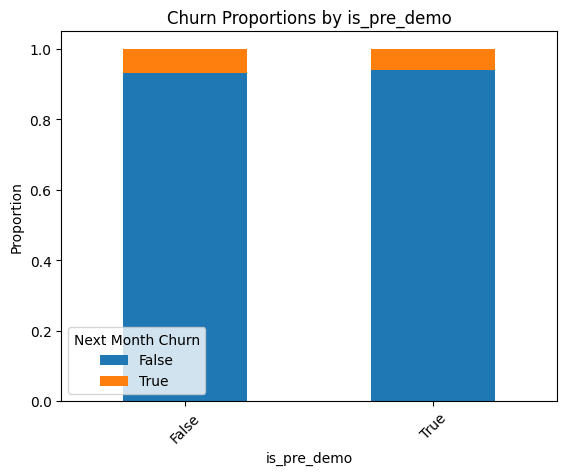

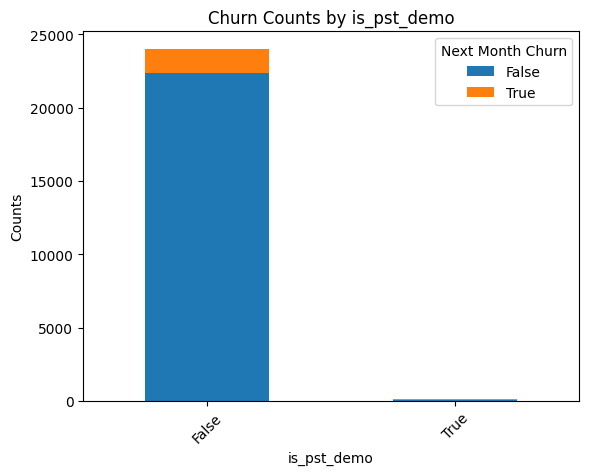

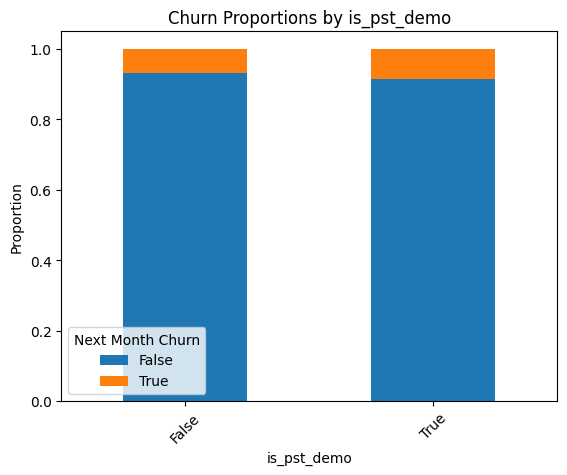

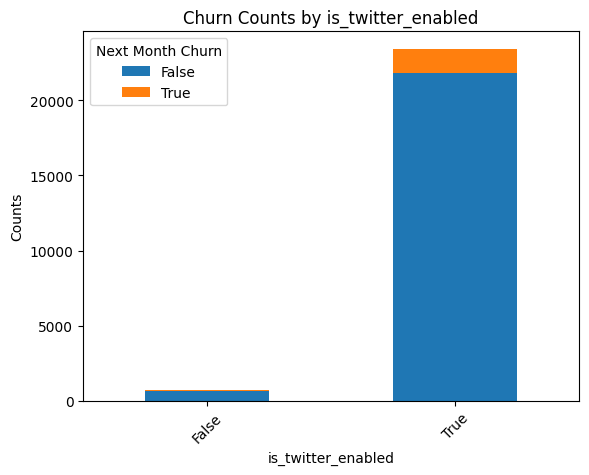

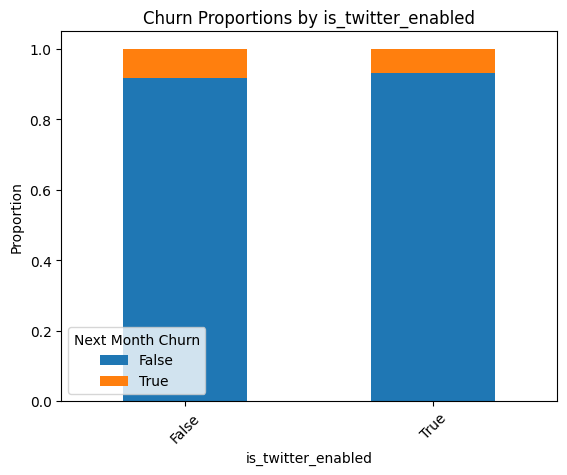

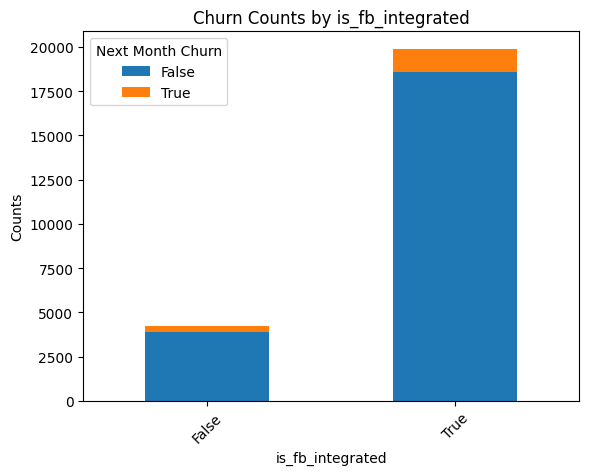

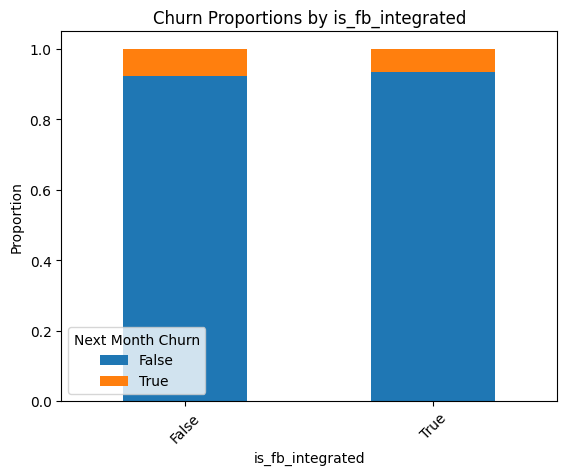

In [19]:
for c in flag_cols: 
    plot_cat_vs_churn(df_monthly, c)

In [20]:
num_cols

['mrr',
 'new_total_mentions',
 'sessions_nr',
 'total_pageviews_nr',
 'min_pv_nr',
 'max_pv_nr',
 'avg_pv_nr',
 'total_session_duration_min',
 'min_sess_min',
 'max_sess_min',
 'avg_sess_min',
 'users_nr',
 'users_limit',
 'subscription_month']

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-pack

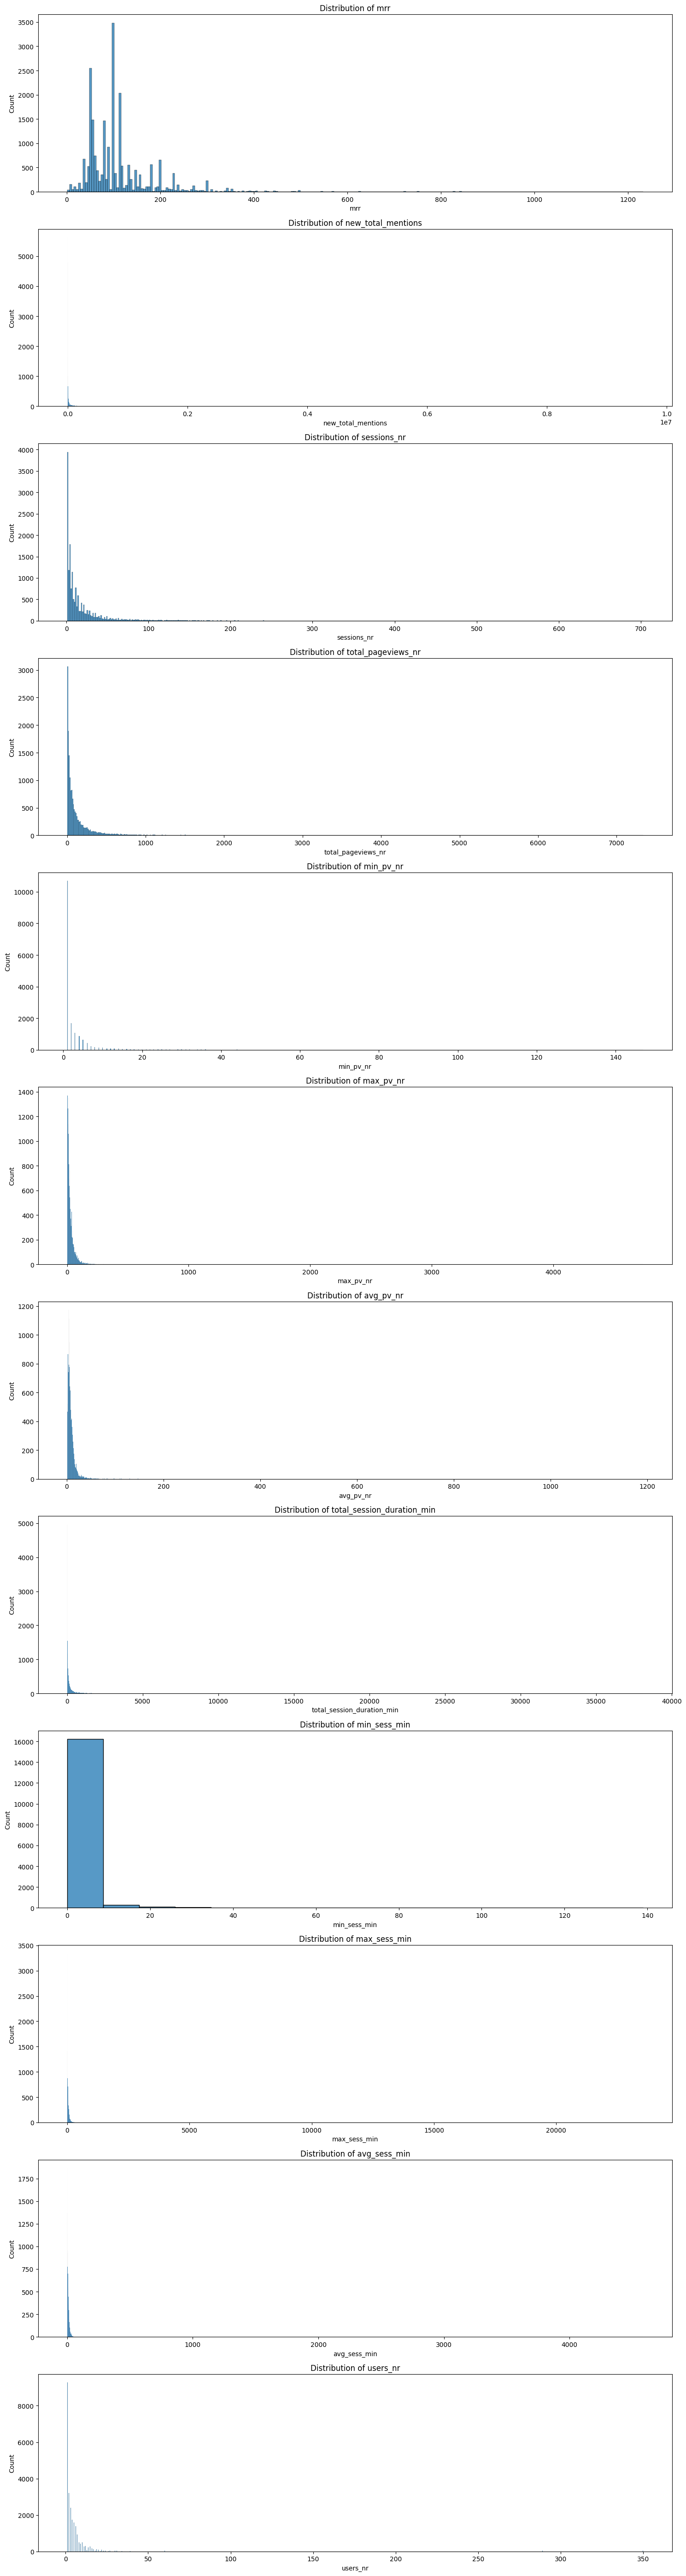

In [21]:
# Plot distributions of numerical variables
plt.figure(figsize=(15, len(num_cols) * 4))

num_cols_to_plot = [c for c in num_cols if c not in ["users_limit", "subscription_month"]]

for i, col in enumerate(num_cols_to_plot, 1):
    plt.subplot(len(num_cols_to_plot), 1, i)
    sns.histplot(df_monthly[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

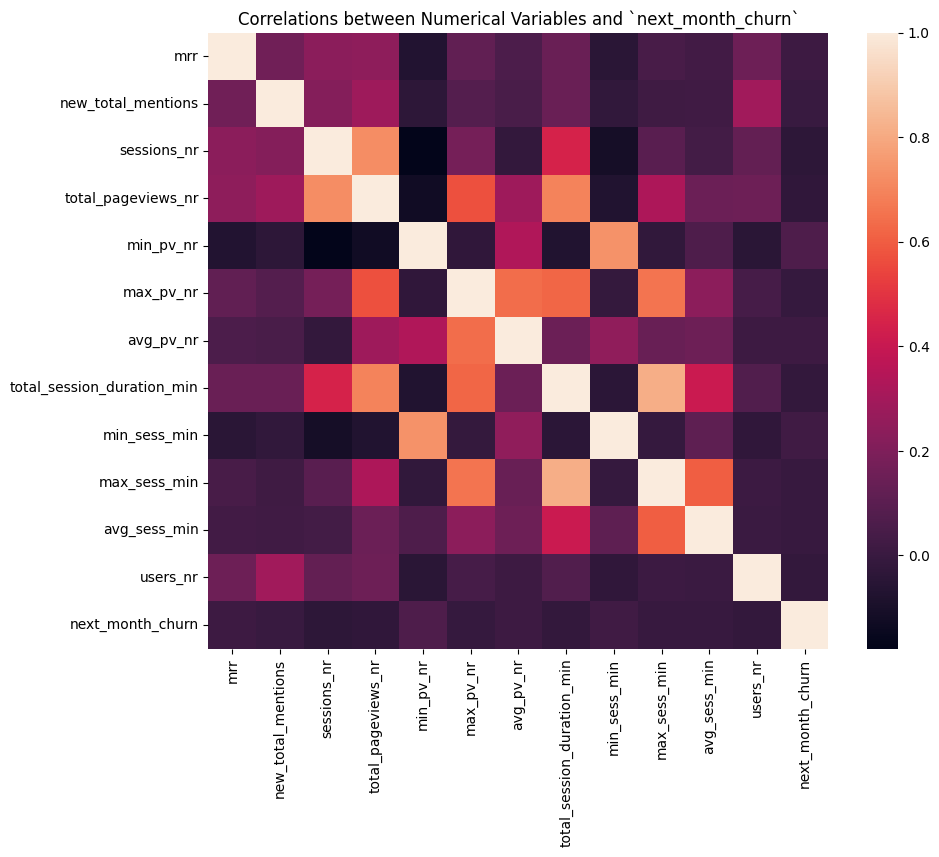

In [22]:
# Calculate correlations
correlations = df_monthly[num_cols_to_plot].join(df_monthly['next_month_churn']).corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations)
plt.title('Correlations between Numerical Variables and `next_month_churn`')
plt.show()

In [23]:
def trend_factor(activities, terms=3):
    if len(activities) < terms:
        return np.nan
    weights = [i + 1 for i in range(terms)]
    a = np.sum([weights[i] * activities[i] for i in range(terms)])
    b = (terms / np.sum(weights))
    return a * b / np.sum(activities)


# Function to apply the trend factor for each eligible segment within a group
def apply_trend_to_group(group, column_name):
    # Ensure there's enough data to calculate the trend
    if len(group) < 3:
        return pd.Series([np.nan] * len(group), index=group.index)
    # Apply trend factor calculation for each point where possible
    trends = [trend_factor(group[column_name].iloc[max(0, i-2):i+1].tolist()) if i >= 2 else np.nan for i in range(len(group))]
    return pd.Series(trends, index=group.index)


# Columns to calculate the trend factor for
columns_to_calculate = [
    'mrr', 'new_total_mentions', 'sessions_nr', 'total_pageviews_nr',
    'min_pv_nr', 'max_pv_nr', 'avg_pv_nr', 'total_session_duration_min',
    'max_sess_min', 'avg_sess_min'
]

# Apply the trend calculation for each specified column and accounts_id group
for column in columns_to_calculate:
    trend_column = f'{column}_trend'
    # Initialize the column to store trend data if not already present
    if trend_column not in df_monthly.columns:
        df_monthly[trend_column] = pd.Series(dtype='float64')
    # Apply the trend factor calculation across the group
    df_monthly[trend_column] = df_monthly.groupby('accounts_id').apply(lambda x: apply_trend_to_group(x, column)).reset_index(level=0, drop=True)

/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_33579/2520868944.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_monthly[trend_column] = df_monthly.groupby('accounts_id').apply(lambda x: apply_trend_to_group(x, column)).reset_index(level=0, drop=True)
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_33579/2520868944.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a * b / np.sum(activities)
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_33579/2520868944.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclu

In [24]:
trend_cols = [c for c in df_monthly.columns if "_trend" in c] 

In [25]:
trend_cols

['mrr_trend',
 'new_total_mentions_trend',
 'sessions_nr_trend',
 'total_pageviews_nr_trend',
 'min_pv_nr_trend',
 'max_pv_nr_trend',
 'avg_pv_nr_trend',
 'total_session_duration_min_trend',
 'max_sess_min_trend',
 'avg_sess_min_trend']

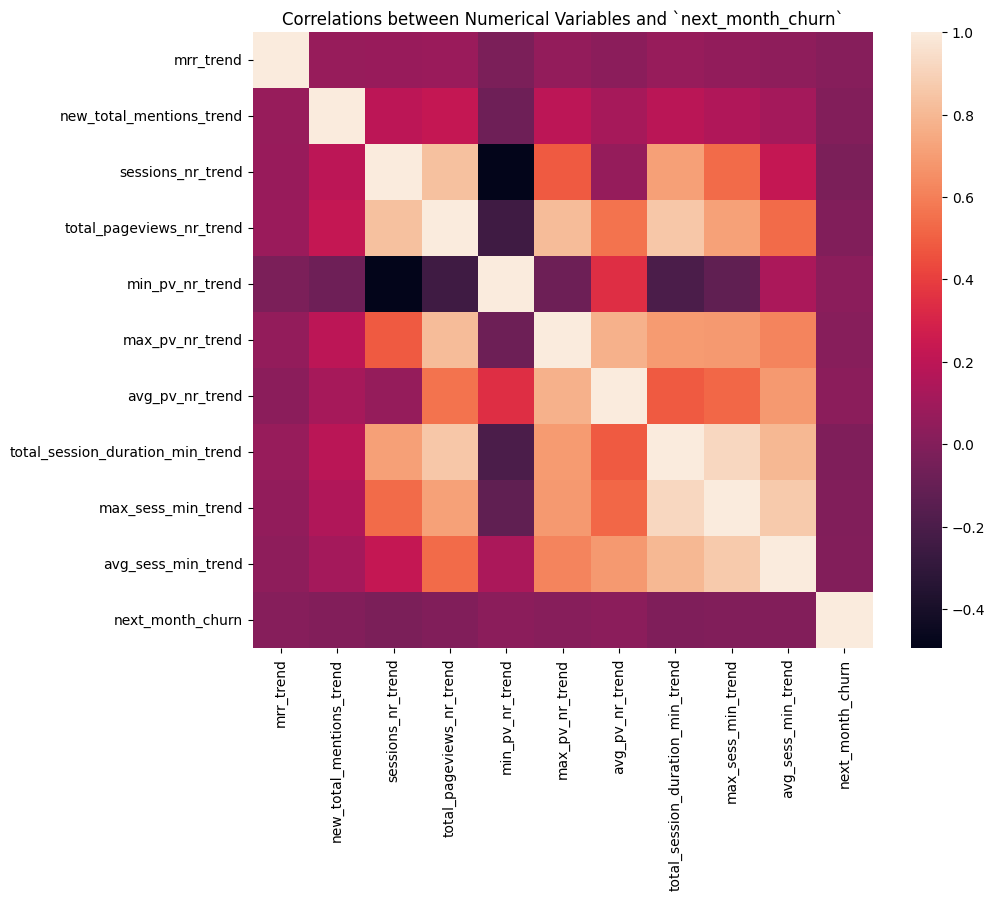

In [26]:
# Calculate correlations
correlations_trend = df_monthly[trend_cols].join(df_monthly['next_month_churn']).corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_trend)
plt.title('Correlations between Numerical Variables and `next_month_churn`')
plt.show()

In [27]:
correlations_trend

,mrr_trend,new_total_mentions_trend,sessions_nr_trend,total_pageviews_nr_trend,min_pv_nr_trend,max_pv_nr_trend,avg_pv_nr_trend,total_session_duration_min_trend,max_sess_min_trend,avg_sess_min_trend,next_month_churn
mrr_trend,1.000000,0.068362,0.073826,0.078844,-0.025615,0.056362,0.028628,0.069462,0.052827,0.035907,0.009203
new_total_mentions_trend,0.068362,1.000000,0.194526,0.227561,-0.071642,0.195939,0.123385,0.191575,0.153294,0.112262,0.000250
sessions_nr_trend,0.073826,0.194526,1.000000,0.836195,-0.495819,0.484688,0.063977,0.711446,0.533921,0.224069,-0.025028
total_pageviews_nr_trend,0.078844,0.227561,0.836195,1.000000,-0.249098,0.813447,0.559348,0.854443,0.717968,0.535721,-0.007154
min_pv_nr_trend,-0.025615,-0.071642,-0.495819,-0.249098,1.000000,-0.076316,0.342723,-0.199767,-0.127616,0.137617,0.028953
max_pv_nr_trend,0.056362,0.195939,0.484688,0.813447,-0.076316,1.000000,0.774049,0.693499,0.689107,0.614362,0.017421
avg_pv_nr_trend,0.028628,0.123385,0.063977,0.559348,0.342723,0.774049,1.000000,0.482471,0.524464,0.687232,0.029279
total_session_duration_min_trend,0.069462,0.191575,0.711446,0.854443,-0.199767,0.693499,0.482471,1.000000,0.920211,0.797813,-0.014937
max_sess_min_trend,0.052827,0.153294,0.533921,0.717968,-0.127616,0.689107,0.524464,0.920211,1.000000,0.868107,-0.009552
avg_sess_min_trend,0.035907,0.112262,0.224069,0.535721,0.137617,0.614362,0.687232,0.797813,0.868107,1.000000,0.000124


### Preparing for modelling

In [28]:
df_ready = df_monthly[df_monthly["subscription_month"] > 2]

In [29]:
df_ready.shape

(20843, 47)

In [30]:
len(df_ready.accounts_id.unique())

1431

In [31]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date_month                        24107 non-null  datetime64[ns]
 1   accounts_id                       24107 non-null  int64         
 2   plan_name                         24090 non-null  object        
 3   mrr                               22712 non-null  float64       
 4   new_total_mentions                22178 non-null  float64       
 5   sessions_nr                       16800 non-null  float64       
 6   total_pageviews_nr                16800 non-null  float64       
 7   min_pv_nr                         16800 non-null  float64       
 8   max_pv_nr                         16800 non-null  float64       
 9   avg_pv_nr                         16800 non-null  float64       
 10  total_session_duration_min        16800 non-nu

#### Train test split

In [32]:
df_ready = df_monthly.copy()

# Identify unique users
unique_accounts = df_ready['accounts_id'].unique()

# Split unique users into training, test, and validation sets
train_users, temp_users = train_test_split(unique_accounts, test_size=0.3, random_state=42)  # 70% for training, 30% for temp (test + validation)
test_users, valid_users = train_test_split(temp_users, test_size=0.5, random_state=42)  # Split the 30% temp into 15% test and 15% validation

# Create DataFrames for each set based on the user splits
train_df = df_ready[df_ready['accounts_id'].isin(train_users)]
test_df = df_ready[df_ready['accounts_id'].isin(test_users)]
valid_df = df_ready[df_ready['accounts_id'].isin(valid_users)]

In [33]:
cols_to_encode = [
    "email_class",
    "plan_name",
    "register_platform",
    "web_mobile",
    "first_device_type",
    "continent",
    "landings_grouped", 
]

In [34]:
# Apply one-hot encoding to 'plan_name' columns in df_ready
df_ready_encoded = pd.get_dummies(df_ready, columns=cols_to_encode)

# Similarly, apply one-hot encoding to the training, testing, and validation sets
train_df = pd.get_dummies(train_df, columns=cols_to_encode)
test_df = pd.get_dummies(test_df, columns=cols_to_encode)
valid_df = pd.get_dummies(valid_df, columns=cols_to_encode)

# Check the new columns created as a result of one-hot encoding
print(df_ready_encoded.columns)

Index(['date_month', 'accounts_id', 'mrr', 'new_total_mentions', 'sessions_nr',
       'total_pageviews_nr', 'min_pv_nr', 'max_pv_nr', 'avg_pv_nr',
       'total_session_duration_min', 'min_sess_min', 'max_sess_min',
       'avg_sess_min', 'is_edu_email', 'is_unknown_region', 'is_organic_sale',
       'is_pre_individual', 'is_pst_individual', 'is_pre_personal',
       'is_pst_personal', 'is_connected', 'is_pst_connected', 'is_pre_demo',
       'is_pst_demo', 'users_nr', 'users_limit', 'is_twitter_enabled',
       'is_fb_integrated', 'next_month_churn', 'subscription_month',
       'mrr_trend', 'new_total_mentions_trend', 'sessions_nr_trend',
       'total_pageviews_nr_trend', 'min_pv_nr_trend', 'max_pv_nr_trend',
       'avg_pv_nr_trend', 'total_session_duration_min_trend',
       'max_sess_min_trend', 'avg_sess_min_trend', 'email_class_x_class',
       'email_class_y_class', 'plan_name_Enterprise', 'plan_name_Individual',
       'plan_name_Pro', 'plan_name_Team', 'register_platform_go

In [36]:
df_ready_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date_month                        24107 non-null  datetime64[ns]
 1   accounts_id                       24107 non-null  int64         
 2   mrr                               22712 non-null  float64       
 3   new_total_mentions                22178 non-null  float64       
 4   sessions_nr                       16800 non-null  float64       
 5   total_pageviews_nr                16800 non-null  float64       
 6   min_pv_nr                         16800 non-null  float64       
 7   max_pv_nr                         16800 non-null  float64       
 8   avg_pv_nr                         16800 non-null  float64       
 9   total_session_duration_min        16800 non-null  float64       
 10  min_sess_min                      16800 non-nu

In [37]:
features = df_ready_encoded.columns.difference(
    [target_col, 'accounts_id', 'date_month']
) 

X_train = train_df[features]
y_train = train_df[target_col]
X_test = test_df[features]
y_test = test_df[target_col]

X_valid = valid_df[features]
y_valid = valid_df[target_col]

# Encode the target variable if it's not already numeric
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_valid = le.transform(y_valid)

### Logistic regression baseline

In [38]:
# Identify numerical columns - adjust as necessary if you have specific columns to include or exclude
numerical_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns

In [39]:
# Define the preprocessing steps for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputes using the mean of each column
    ('scaler', StandardScaler())  # Standardizes the data
])

# Combine the preprocessing steps
# If you have categorical data to preprocess, add another transformer here
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
        # Add other transformers here for categorical data if needed
    ],
    remainder='passthrough'  # Indicates what to do with columns not explicitly selected
)

# Apply the preprocessing pipeline to the feature data
# This does not include the target variable
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.fit_transform(X_test)
X_valid_preprocessed = preprocessor.fit_transform(X_valid)

In [40]:
lr = LogisticRegression()
lr.fit(X_train_preprocessed, y_train)

LogisticRegression()

In [41]:
# Predict on the test set
y_pred_lr = lr.predict(X_test_preprocessed)
y_pred_proba_lr = lr.predict_proba(X_test_preprocessed)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3342
           1       0.60      0.01      0.02       245

    accuracy                           0.93      3587
   macro avg       0.77      0.51      0.49      3587
weighted avg       0.91      0.93      0.90      3587

ROC-AUC Score: 0.7479805566750937


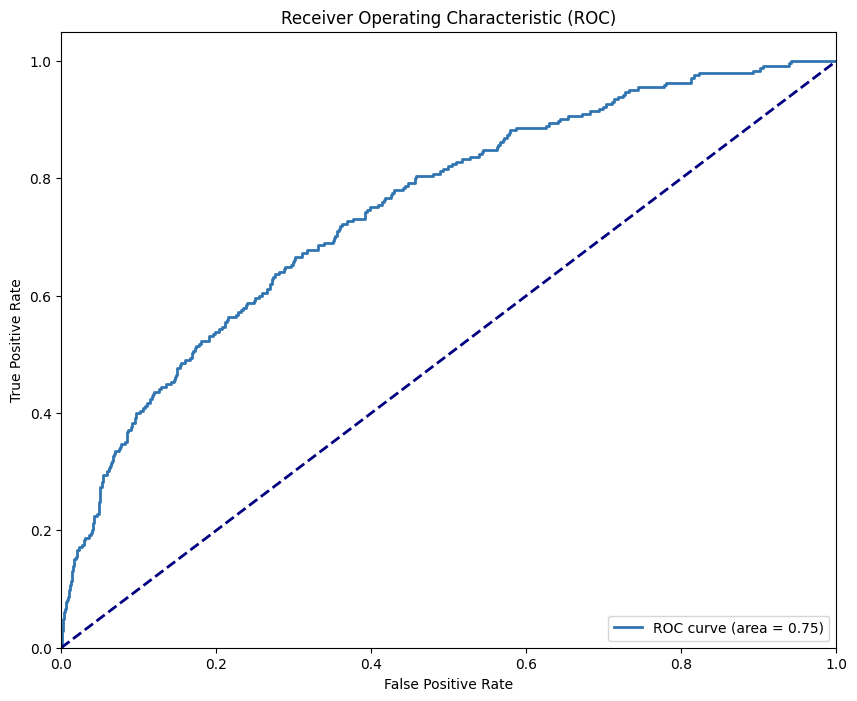

In [43]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='#3075B1', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

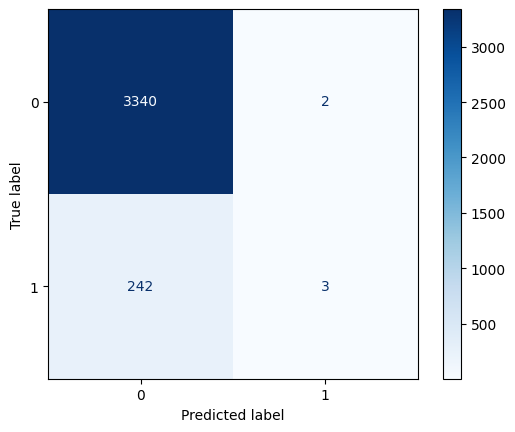

In [44]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### XGBoost

In [45]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
    }
    
    # Train the model
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    # Predict and calculate ROC-AUC score
    preds = model.predict_proba(X_valid)[:,1]
    roc_auc = roc_auc_score(y_valid, preds)
    
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best trial
trial = study.best_trial
print(f'ROC-AUC: {trial.value}')
print("Best hyperparameters: {}".format(trial.params))

[I 2024-02-22 12:55:26,403] A new study created in memory with name: no-name-d5ca0a7a-b588-41a3-b4bc-f03f6629345f
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_33579/4189800484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_33579/4189800484.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_33579/4189800484.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

ROC-AUC: 0.8431065759637189
Best hyperparameters: {'lambda': 0.9909822537882534, 'alpha': 0.5302595664929599, 'max_depth': 6, 'eta': 0.11353796265150641, 'scale_pos_weight': 14.156483061711999, 'subsample': 0.9082156056132993, 'colsample_bytree': 0.6470785772932944}


In [46]:
# best params saved in comment
# {'lambda': 0.03458496210025564,
#  'alpha': 3.279254837791355e-06,
#  'max_depth': 5,
#  'eta': 0.17284397517611988,
#  'scale_pos_weight': 11.543528704094477,
#  'subsample': 0.8866246731959396,
#  'colsample_bytree': 0.6377699215995204}

In [48]:
# best params from optuna
best_params = {'lambda': 0.03458496210025564,
 'alpha': 3.279254837791355e-06,
 'max_depth': 5,
 'eta': 0.17284397517611988,
 'scale_pos_weight': 11.543528704094477,
 'subsample': 0.8866246731959396,
 'colsample_bytree': 0.6377699215995204}

In [49]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(**best_params) 
model.fit(X_train, y_train)

XGBClassifier(alpha=3.279254837791355e-06, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6377699215995204, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.17284397517611988, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.03458496210025564,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [50]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      3342
           1       0.28      0.55      0.37       245

    accuracy                           0.87      3587
   macro avg       0.62      0.72      0.65      3587
weighted avg       0.92      0.87      0.89      3587

ROC-AUC Score: 0.8201443593595428


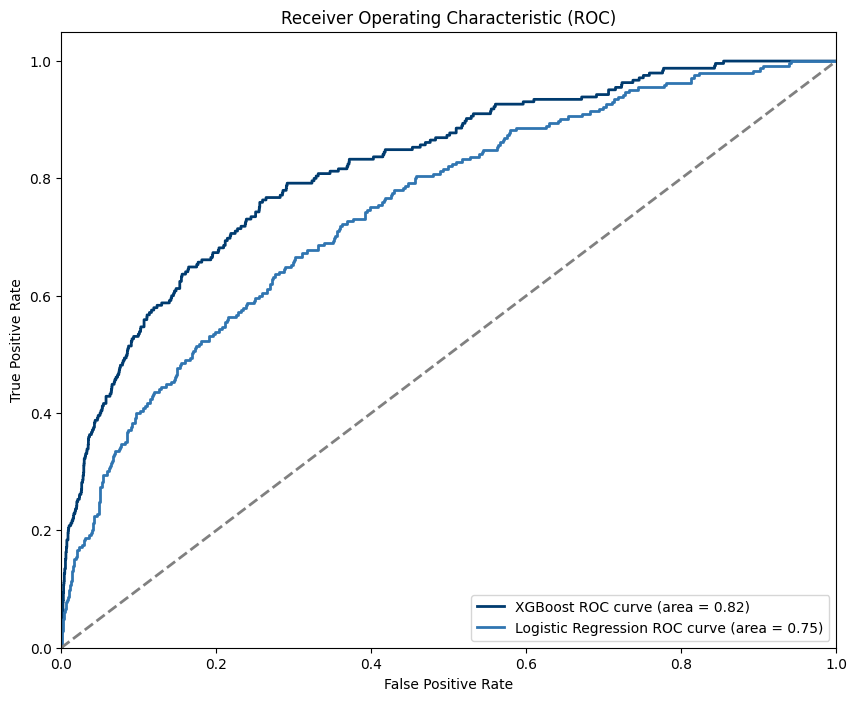

In [51]:
# Assuming y_test contains true labels and y_pred_proba contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Calculate AUC

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#003B6F', lw=2, label='XGBoost ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_lr, tpr_lr, color='#3075B1', lw=2, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

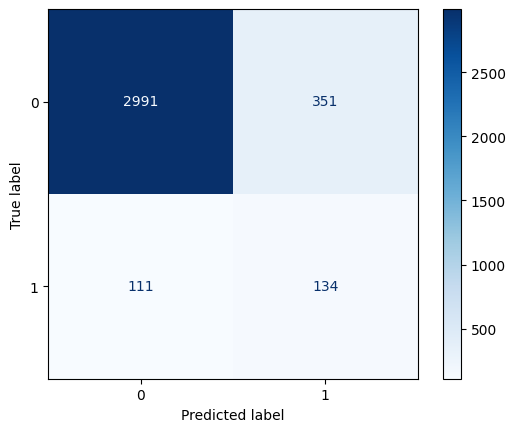

In [52]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [54]:
# This gets the feature importance for all features
feature_importances = model.get_booster().get_score(importance_type='weight')

In [55]:
import pandas as pd

# Convert to a DataFrame for easier handling
feature_importances_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

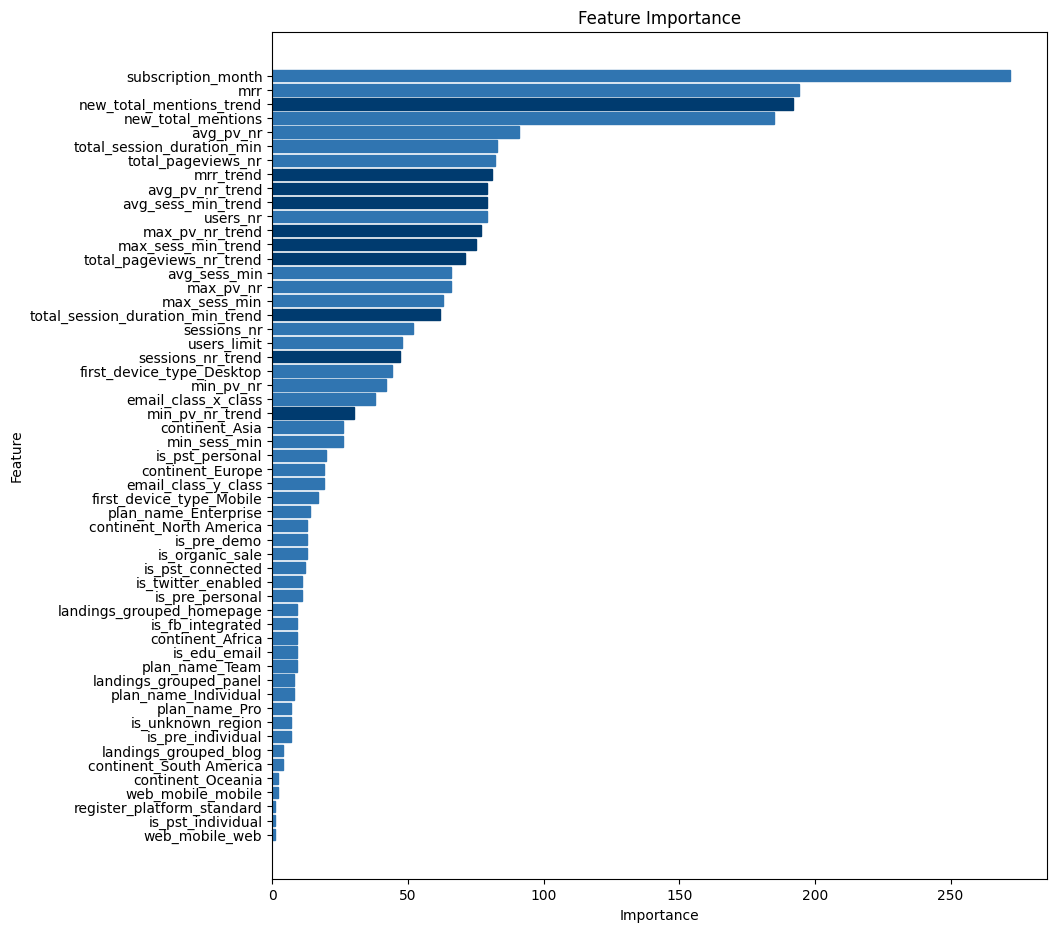

In [56]:
plt.figure(figsize=(10, 11))
bars = plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])

# Iterate over the bars and the feature names together
for bar, feature in zip(bars, feature_importances_df['Feature']):
    if 'trend' in feature:
        bar.set_color('#003B6F')
    else:
        bar.set_color('#3075B1')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()